In [ ]:
import fine_tunned_bert

Mounted at /content/gdrive
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 76 kB 3.5 MB/s 
  Created wheel for reload: filename=reload-0.9-py3-none-any.whl size=2880 sha256=3b8d403d8f766c7f8a2660afc62c9fd309343478f5b3531369c66839e194898e
  Stored in directory: /root/.cache/pip/wheels/f1/a2/ff/3f7b4879e081247a0e1381fd6699e86e0732ca0c365be41634
Successfully built reload
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'fine_tunned_bert' from '/content/gdrive/Shared drives/PFE/Colab Notebooks/fine_tunned_bert.py'>

In [3]:
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt
from tensorflow.keras import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
bert_model_name='small_bert/bert_en_uncased_L-4_H-512_A-8'

In [4]:
df = pd.read_csv('./data/authority_dataset.csv')
df

,ad,auth
0,north korea officially has no corona cases how...,1
1,it seems difficult to stand for something one ...,0
2,senator bernie sanders held a rally with randy...,1
3,life gets busy—don’t wait to send back your ba...,0
4,some issues feel impossible to compromise on b...,1
...,...,...
49661,a recent poll shows sherrod with just a one po...,0
49662,today’s donor goal ⃣ ⃣ ⃣ our endofquarter dead...,0
49663,you’ve been selected after a year of chaos hat...,1
49664,after receiving the corona vaccine a video tha...,0


In [9]:
# build test and training datasets 
cleaned_train, cleaned_test, y_train, y_test = train_test_split(df['ad'], df['auth'] , test_size = 0.2, random_state = 42 , shuffle = True)
cleaned_train, cleaned_val, y_train, y_val = train_test_split(cleaned_train, y_train,  test_size=0.25, random_state= 42, shuffle = True)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(  (cleaned_train,y_train) ).batch(32)
val_data = tf.data.Dataset.from_tensor_slices( (cleaned_val,y_val) ).batch(32)
test_data = tf.data.Dataset.from_tensor_slices( (cleaned_test,y_test) ).batch(32)

# create the fine_tunned_model
bert_model = fine_tunned_bert.create_fine_tunned_bert(train_data,bert_model_name=bert_model_name)

# training the model
history = bert_model.fit(x=train_data,epochs =5,validation_data = val_data,verbose=False)

# evaluation 
scores = bert_model.evaluate(test_data)
print("-----------------------------------------")
predictions=bert_model.predict(cleaned_test)
results = (predictions>0.5)*1
tn, fp, fn, tp = confusion_matrix(y_test,results).ravel()
print("Fold cofusion matrix")
print((tn, fp, fn, tp))
print("-----------------------------------------")


469/469 [==============================] - 46s 98ms/step - loss: 0.0989 - accuracy: 0.9801 - precision: 0.9821 - recall: 0.9776 - auc: 0.9901
-----------------------------------------
Fold cofusion matrix
(7457, 132, 166, 7245)
-----------------------------------------


In [ ]:
# model evaluation 
scores = bert_model.evaluate(test_data)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 46s 98ms/step - loss: 0.0989 - accuracy: 0.9801 - precision: 0.9821 - recall: 0.9776 - auc: 0.9901
Accuracy: 98.01%


In [ ]:
print(metrics.classification_report(y_test, results, target_names=[ 'no-scarcity', 'scarcity']))


skplt.metrics.plot_confusion_matrix(y_test, results , normalize=True)
plt.show()

              precision    recall  f1-score   support

 no-scarcity       0.98      0.98      0.98      7589
    scarcity       0.98      0.98      0.98      7411

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [ ]:
save = pd.read_csv('./data/validation_dataset.csv')

predictions = bert_model.predict(save['ad'])
results = (predictions>0.5)*1

print(metrics.classification_report(save['auth'], results, target_names=[ 'no-auth', 'auth']))

              precision    recall  f1-score   support

     no-auth       0.98      0.98      0.98      8649
        auth       0.98      0.98      0.98      8650

    accuracy                           0.98     17299
   macro avg       0.98      0.98      0.98     17299
weighted avg       0.98      0.98      0.98     17299



In [ ]:
save = pd.read_csv('./data/sample_auth.csv')

save=save.sample(frac=1)


save.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
save['ad'] = save['ad'].str.strip().str.lower() 

# Expand contractions 
save['ad'] = save['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
save['ad'] =  save['ad'].str.translate(str.maketrans('','',string.punctuation))

test_data = tf.data.Dataset.from_tensor_slices( (save['ad'],save['authority']) ).batch(32)
# model evaluation 
scores = bert_model.evaluate(test_data)
print("Accuracy: %.2f%%" % (scores[1]*100))


4/4 [==============================] - 1s 158ms/step - loss: 1.8622 - accuracy: 0.7685 - precision: 0.8222 - recall: 0.6852 - auc: 0.7603
Accuracy: 76.85%


confusion matrix:
[[46  8]
 [17 37]]



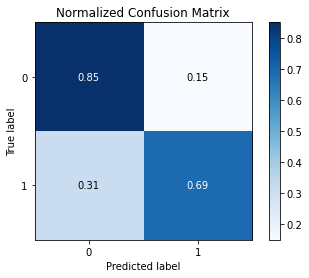

In [ ]:
from sklearn import metrics
pred_ =  bert_model.predict(save['ad'])
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['authority'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['authority'], save['predicted'], normalize=True)
plt.show()

In [ ]:
print(metrics.classification_report(save['authority'], save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))

              precision    recall  f1-score   support

 no-scarcity       0.73      0.85      0.79        54
    scarcity       0.82      0.69      0.75        54

    accuracy                           0.77       108
   macro avg       0.78      0.77      0.77       108
weighted avg       0.78      0.77      0.77       108

